# Battery Data Analysis and Degradation Modelling
This notebook analyzes battery degradation behavior using capacity, current, voltage, and cycle information.

In [ ]:
%cd ./files

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Load dataset
df = pd.read_csv('001_2.csv')
df2 = pd.read_csv('002_4.csv')

# pd.concat([df2,df1], ignore_index=True).to_csv('combined.csv', index=False)


> **Note:**  
> After analyzing the dataset, it can be concluded that these datasets are not of the same battery configuration. Hence, it is not wise to combine them into one. Therefore, I decided to analyze them separately.

## Data Overview and Cleaning
To get familiar with dataset attribute's datatypes and To clean dataset from missing values

In [32]:
# Removing incomplete cycles. Keeping only cycles that have both positive and negative current values
valid_cycles = df.groupby('Cycle_Index')['Current(A)'].apply(lambda x: (x > 0).any() and (x < 0).any())
valid_cycles2 = df2.groupby('Cycle_Index')['Current(A)'].apply(lambda x: (x > 0).any() and (x < 0).any())
df = df[df['Cycle_Index'].isin(valid_cycles[valid_cycles].index)]
df2 = df2[df2['Cycle_Index'].isin(valid_cycles[valid_cycles].index)]

# Removing Missing Values
df = df.dropna()
df2 = df2.dropna()

# Resetting index after filtering
df.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

# Understanding the data
print(df.describe())
print(df2.describe())

          Data_Point     Current(A)   Capacity(Ah)     Voltage(V)  \
count  122992.000000  122992.000000  122992.000000  122992.000000   
mean    63222.500000       0.014560       0.525955       3.701242   
std     35504.876491       5.183224       0.351569       0.298134   
min      1727.000000      -7.207000       0.000000       2.999400   
25%     32474.750000      -7.194000       0.295000       3.480300   
50%     63222.500000       0.000000       0.431000       3.710600   
75%     93970.250000       7.194000       0.722000       3.932600   
max    124718.000000       7.207000       1.512000       4.200800   

          Energy(Wh)    Cycle_Index  
count  122992.000000  122992.000000  
mean        1.957868      43.735446  
std         1.330332      28.798950  
min         0.000000       2.000000  
25%         1.029000      18.000000  
50%         1.603500      40.000000  
75%         2.696000      68.000000  
max         6.069000     100.000000  
          Data_Point     Current(A) 

## Feature Engineering

This section focuses on transforming and enriching the dataset for further analysis:

- **Parsing `Test_Time(s)`**: Converts time strings in the format `HH:MM:SS` or `d-HH:MM:SS` into total elapsed seconds, making time-based calculations straightforward.
- **Handling Mixed Formats**: Uses regular expressions and logic to correctly interpret both standard and day-prefixed time formats.
- **Adding Derived Columns**:
    - **`Time_Diff(s)`**: Calculates the difference in elapsed time between consecutive rows, representing the duration of each measurement step.



In [33]:
import re
from datetime import timedelta

def parse_test_time(time_str):
    """Parses d-HH:MM:SS or HH:MM:SS strings into total seconds."""
    if isinstance(time_str, str):
        if '-' in time_str:
            day_part, time_part = time_str.split('-')
            d = int(day_part)
        else:
            time_part = time_str
            d = 0
        h, m, s = map(int, time_part.split(':'))
        return int(timedelta(days=d, hours=h, minutes=m, seconds=s).total_seconds())
    else:
        return time_str  # return original if not a string

df['Test_Time(s)'] = df['Test_Time(s)'].apply(parse_test_time)
df2['Test_Time(s)'] = df2['Test_Time(s)'].apply(parse_test_time)

df['Time_Diff(s)'] = df['Test_Time(s)'].diff().fillna(1)
df2['Time_Diff(s)'] = df2['Test_Time(s)'].diff().fillna(1)

### Extract Charging and Discharging Phases
In this block, I extract non-zero values for charging cycle and discharging cycle.

In [34]:
charging_df = df[df['Current(A)'] > 0].copy()
discharging_df = df[df['Current(A)'] < 0].copy()

charging_df2 = df2[df2['Current(A)'] > 0].copy()
discharging_df2 = df2[df2['Current(A)'] < 0].copy()

### Compute Capacity per Cycle

This section calculates the **maximum charge and discharge capacity** for each battery cycle:

- **Charge Capacity:**  
    For each cycle, the maximum value of `Capacity(Ah)` during charging is taken as the cycle's charge capacity.

- **Discharge Capacity:**  
    Similarly, the maximum value of `Capacity(Ah)` during discharging is used for the cycle's discharge capacity.

Tracking these values over cycles provides insight into how the battery's ability to store and deliver energy changes with use, which is essential for understanding degradation trends.

In [35]:
charge_capacity = charging_df.groupby('Cycle_Index')['Capacity(Ah)'].max().reset_index()
discharge_capacity = discharging_df.groupby('Cycle_Index')['Capacity(Ah)'].max().reset_index()

charge_capacity2 = charging_df2.groupby('Cycle_Index')['Capacity(Ah)'].max().reset_index()
discharge_capacity2 = discharging_df2.groupby('Cycle_Index')['Capacity(Ah)'].max().reset_index()

# Visualization

### Charge/Discharge Capacity vs Cycle

**Observation:**  
The plot below illustrates how both charging and discharging capacities decline as the cycle count increases, highlighting the battery's degradation over time.

- Both charge and discharge capacities show an exponential-like decrease with each cycle, indicating a progressive loss of battery efficiency and storage capability.
- This trend provides a clear overview of the battery's aging process as the number of cycles increases.
- Upon looking, **Battery 002_4 retained better Charging capacity compared to 001_2 throughout cycles**.

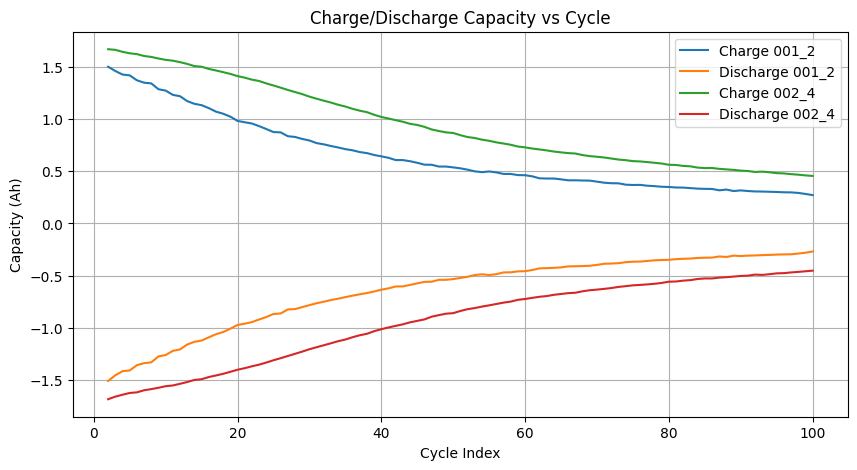

In [36]:
plt.figure(figsize=(10, 5))

plt.plot(charge_capacity['Cycle_Index'], charge_capacity['Capacity(Ah)'], label='Charge 001_2')
plt.plot(discharge_capacity['Cycle_Index'], discharge_capacity['Capacity(Ah)'] * -1, label='Discharge 001_2')

plt.plot(charge_capacity2['Cycle_Index'], charge_capacity2['Capacity(Ah)'], label='Charge 002_4')
plt.plot(discharge_capacity2['Cycle_Index'], discharge_capacity2['Capacity(Ah)'] * -1, label='Discharge 002_4')

plt.xlabel('Cycle Index')
plt.ylabel('Capacity (Ah)')
plt.title('Charge/Discharge Capacity vs Cycle')
plt.legend()
plt.grid(True)
plt.show()

## Voltage vs. Charge and Discharge Capacity

The following visualizations show the relationship between battery voltage and capacity during both charging and discharging phases:

- **Voltage vs. Charge Capacity:** Illustrates how the voltage changes as the battery is charged, helping to identify charging characteristics and plateaus.
- **Voltage vs. Discharge Capacity:** Shows voltage behavior during discharge, which is useful for analyzing battery efficiency and end-of-discharge voltage.

**Observations:**
- When the battery is fully charged, the voltage reaches approximately **4.2 V**.
- When the battery is fully discharged, the voltage drops to around **3.0 V**.
- The voltage reduces more rapidly as cycle count increases and the battery degrades.

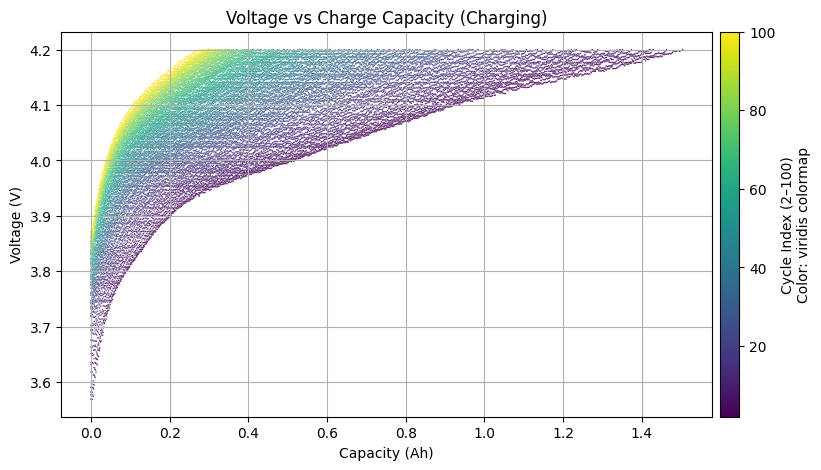

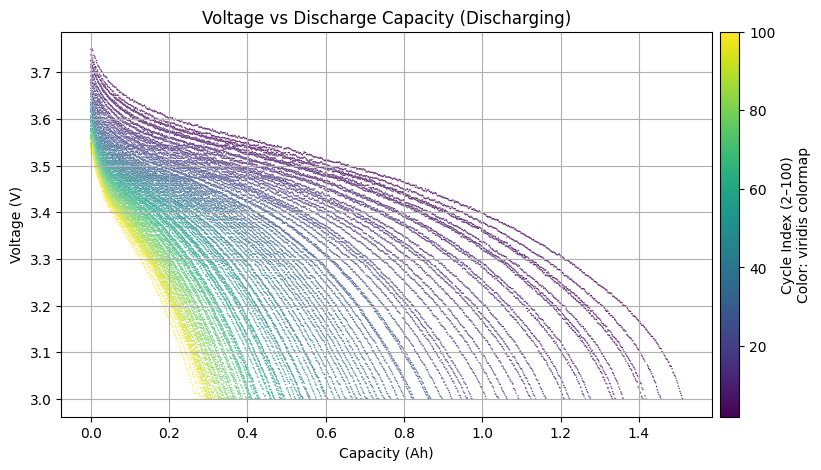

In [37]:
plt.figure(figsize=(10, 5))
scatter = sns.scatterplot(
    x='Capacity(Ah)',
    y='Voltage(V)',
    hue='Cycle_Index',
    palette='viridis',
    data=charging_df,
    s=1,
    legend=False
)
plt.title('Voltage vs Charge Capacity (Charging)')
plt.xlabel('Capacity (Ah)')
plt.ylabel('Voltage (V)')
plt.grid(True)

# Add colorbar for Cycle_Index
norm = plt.Normalize(charging_df['Cycle_Index'].min(), charging_df['Cycle_Index'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.01)
cbar.set_label(f'Cycle Index ({charging_df["Cycle_Index"].min()}–{charging_df["Cycle_Index"].max()})\nColor: viridis colormap')

plt.show()

plt.figure(figsize=(10, 5))
scatter = sns.scatterplot(
    x='Capacity(Ah)',
    y='Voltage(V)',
    hue='Cycle_Index',
    palette='viridis',
    data=discharging_df,
    s=1,
    legend=False
)
plt.title('Voltage vs Discharge Capacity (Discharging)')
plt.xlabel('Capacity (Ah)')
plt.ylabel('Voltage (V)')
plt.grid(True)

# Add colorbar for Cycle_Index
norm = plt.Normalize(discharging_df['Cycle_Index'].min(), discharging_df['Cycle_Index'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.01)
cbar.set_label(f'Cycle Index ({discharging_df["Cycle_Index"].min()}–{discharging_df["Cycle_Index"].max()})\nColor: viridis colormap')

plt.show()

## Influence of C-rate
- The charging rate, represented as **C-rate**, has a significant impact on the effective charge capacity of the battery.  
    **Higher C-rates (faster charging) typically result in lower measured capacities** due to increased internal resistance and heat generation, which reduce the efficiency of the electrochemical reactions.

- As the battery is charged more quickly, it is less able to accept and store its full rated capacity.

- The plot below visualizes this relationship, showing that **higher C-rates correspond to lower charge capacities**, highlighting the trade-off between charging speed and battery performance.

- **Formula used:**  
    $$
    \text{C\_rate} = \frac{\text{Current}}{\text{Full Charge Capacity of current cycle}}
    $$

In [38]:
# For first dataset
curr_Charge_Capacity = charging_df.groupby('Cycle_Index')['Capacity(Ah)'].max().reset_index()
curr_current = charging_df.groupby('Cycle_Index')['Current(A)'].mean().reset_index()
curr_C_rate= curr_current['Current(A)'] / curr_Charge_Capacity['Capacity(Ah)']

# For second dataset
curr_Charge_Capacity2 = charging_df2.groupby('Cycle_Index')['Capacity(Ah)'].max().reset_index()
curr_current2 = charging_df2.groupby('Cycle_Index')['Current(A)'].mean().reset_index()
curr_C_rate2 = curr_current2['Current(A)'] / curr_Charge_Capacity2['Capacity(Ah)']

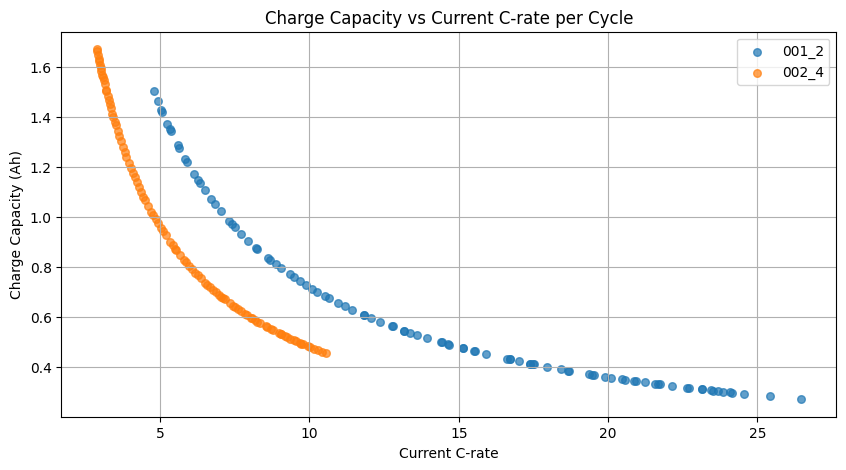

In [39]:
plt.figure(figsize=(10, 5))

plt.scatter(curr_C_rate, curr_Charge_Capacity['Capacity(Ah)'], s=30, alpha=0.7, label='001_2')
plt.scatter(curr_C_rate2, curr_Charge_Capacity2['Capacity(Ah)'], s=30, alpha=0.7, label='002_4')

plt.legend()
plt.xlabel('Current C-rate')
plt.ylabel('Charge Capacity (Ah)')
plt.title('Charge Capacity vs Current C-rate per Cycle')
plt.grid(True)
plt.show()

> **Note:**  
> In the analysis above, the **C-rate** was calculated using the **current charging capacity (i.e., the maximum charge capacity of each cycle)** rather than the nominal (designed) cell capacity as described in the documentation. This approach reflects the actual, cycle-specific charge acceptance of the battery, and the resulting plot shows the relationship between **measured charge capacity and the C-rate based on the current cycle's full charge capacity**.  
>  
> In contrast, the documentation formula uses the designed (initial) capacity, which does not account for degradation over cycles. Using the current capacity provides a more accurate, real-time view of battery performance as it ages.

## Polynomial Regression for Degradation
Polynomial regression can be used to model the nonlinear degradation of battery charge capacity over cycles. By fitting a second-degree polynomial to the charge capacity data (`Capacity(Ah)`) as a function of cycle index, we can capture the curvature in the degradation trend. The fitted curve (in red) provides a smoothed estimate of capacity loss, helping to visualize and quantify the rate at which the battery degrades with use. This approach is useful for predicting future capacity and understanding the underlying degradation mechanisms.

Using this cell, I would fit 
$$
y = \beta_0 + \beta_1 x + \beta_2 x^2
$$



In [40]:
# Prepare data for regression
X = charge_capacity['Cycle_Index'].values.reshape(-1, 1)
y = charge_capacity['Capacity(Ah)'].values

Train R2: 0.9936207922202634
Test R2 : 0.9932526280309658
Test RMSE: 0.0001768777133640782


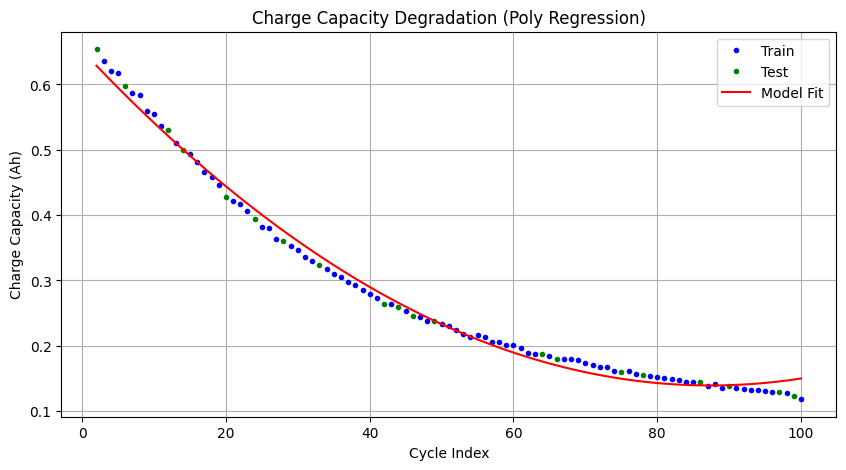

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Split data (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize y_train, y_test with initial charge capacity
initial_capacity = 2.3
y_train = y_train / initial_capacity
y_test = y_test / initial_capacity

# Train model
poly_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly_model.fit(X_train, y_train)

# Predict
y_pred_train = poly_model.predict(X_train)
y_pred_test = poly_model.predict(X_test)

# Evaluation
print("Train R2:", r2_score(y_train, y_pred_train))
print("Test R2 :", r2_score(y_test, y_pred_test))
print("Test RMSE:", mean_squared_error(y_test, y_pred_test))

plt.figure(figsize=(10, 5))
plt.plot(X_train, y_train, 'b.', label='Train')
plt.plot(X_test, y_test, 'g.', label='Test')
plt.plot(X, poly_model.predict(X), 'r-', label='Model Fit')
plt.title('Charge Capacity Degradation (Poly Regression)')
plt.xlabel('Cycle Index')
plt.ylabel('Charge Capacity (Ah)')
plt.legend()
plt.grid(True)
plt.show()


Extracting Coefficients of Best Fitted Curve

In [42]:
# Extract fitted coefficients from poly_model (sklearn pipeline)
coefs = poly_model.named_steps['linearregression'].coef_
intercept = poly_model.named_steps['linearregression'].intercept_
print("Coefficients:", coefs)
print("Intercept:", intercept)

Coefficients: [ 0.00000000e+00 -1.17285374e-02  6.71040882e-05]
Intercept: 0.651820951991738


> **Note:**  
While **deep learning techniques** (such as neural networks) could be applied to model battery degradation, they are likely overkill for this task. The underlying relationship between cycle count and capacity loss is **well-understood** and can be effectively captured using simple polynomial regression or other classical machine learning methods. This approach offers **greater interpretability, generalization** and requires **less data and computational resources**.

## State of Health (SoH)

**State of Health (SoH)** is a key metric for assessing battery degradation over cycles.  
It is defined as the ratio of the current charge capacity to the initial capacity, expressed as a percentage:

$$
\text{SoH} = \frac{\text{Current Charge Capacity}}{\text{Initial Capacity}} \times 100
$$

Tracking SoH over time allows us to monitor how the battery's ability to hold charge declines with each cycle.  
A decreasing SoH indicates progressive battery degradation.


**Observation**
- **Battery 002_4 have better SoH compared to 001_2 throughout cycles**.


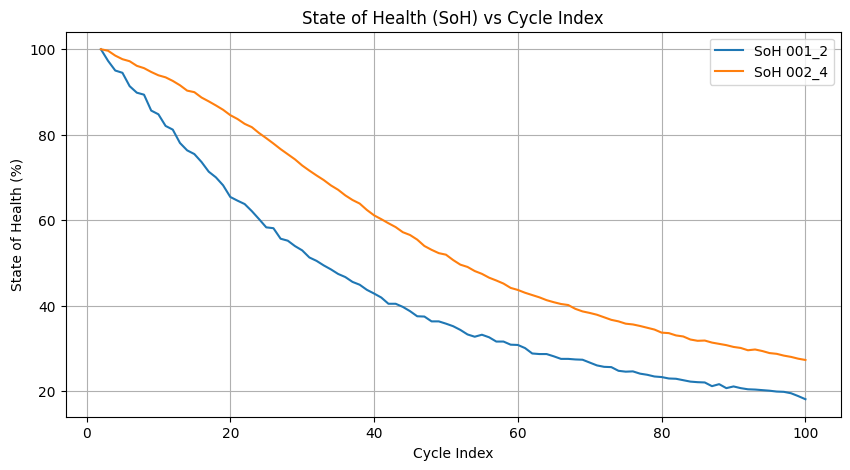

In [43]:
# 1st Cycle's Calculated Charge Capacity
initial_capacity = charge_capacity['Capacity(Ah)'].iloc[0]
charge_capacity['SoH'] = charge_capacity['Capacity(Ah)'] / initial_capacity * 100

# 2nd Cycle's Calculated Charge Capacity
initial_capacity2 = charge_capacity2['Capacity(Ah)'].iloc[0]
charge_capacity2['SoH'] = charge_capacity2['Capacity(Ah)'] / initial_capacity2 * 100

plt.figure(figsize=(10, 5))
plt.plot(charge_capacity['Cycle_Index'], charge_capacity['SoH'], label='SoH 001_2')
plt.plot(charge_capacity2['Cycle_Index'], charge_capacity2['SoH'], label='SoH 002_4')
plt.xlabel('Cycle Index')
plt.ylabel('State of Health (%)')
plt.title('State of Health (SoH) vs Cycle Index')
plt.legend()
plt.grid(True)
plt.show()

## Conclusions

- **Capacity decreases over cycles indicating battery degradation:**  
    As the battery undergoes repeated charge/discharge cycles, its ability to store energy (capacity) declines. This is evident from the downward trend in the capacity vs. cycle plots, reflecting the natural aging and wear-out mechanisms in battery chemistry.

- **High C-rate reduces effective charge capacity:**  
    The C-rate represents the rate at which the battery is charged or discharged relative to its maximum capacity. Higher C-rates (faster charging/discharging) typically lead to lower measured capacities due to increased internal losses and less efficient electrochemical reactions.

- **State of Health gives a clear view of degradation trends:**  
    State of Health (SoH) quantifies the battery's current capacity as a percentage of its initial capacity. Tracking SoH over cycles provides a straightforward metric to monitor and visualize the extent of battery degradation.

- **Polynomial regression provides a good fit for capacity loss over time:**  
    Battery degradation is often nonlinear. Polynomial regression captures the curvature in the capacity decline, offering a more accurate and interpretable model for predicting future capacity and understanding the degradation pattern.
- **Battery 002_4 offers better alternative than Battery 001_2** based on better SoH & Charge Capacity after 100 Cycles.

---